# **Analis Sentimen **

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import re
import string
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.initializers import Constant
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Dropout, Dense

import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from indoNLP.preprocessing import replace_slang

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

SEED = 42
MODEL = 'id-wiki-word2vec-bilstm'
FOLDER_PATH = 'model-baseline-bilstm'

np.random.seed(SEED)
tf.random.set_seed(SEED)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\TUF
[nltk_data]     Gaming\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [2]:
df = pd.read_csv("korupsi_uhuy.csv")
# df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)   # For shuffle
print(df.head())

                                           full_text    label  \
0  Eks Menteri BUMN Dahlan Iskan  memenuhi panggi...   netral   
1  Dalam mencegah tindak pidana korupsi yang mara...  positif   
2  Unit Tipikor Satreskrim Polrestabes Medan mela...  positif   
3  Kejagung Akui Kesulitan Temukan Tersangka Koru...  negatif   
4  Usai menjalani sidang tuntutan di Pengadilan T...   netral   

                                    text_normalisasi  
0  eks menteri badan usaha milik negara dahlan is...  
1  dalam mencegah tindak pidana korupsi yang mara...  
2  unit tipikor satreskrim polrestabes medan mela...  
3  kejaksaan agung akui kesulitan temukan tersang...  
4  usai menjalani sidang tuntutan di pengadilan t...  


In [61]:
print(df.dtypes)

full_text           object
label               object
text_normalisasi    object
dtype: object


In [3]:
s_1 = df[df['label']=='positif'].sample(900,replace=True)
s_2 = df[df['label']=='netral'].sample(900,replace=True)
s_3 = df[df['label']=='negatif'].sample(900,replace=True)
df = pd.concat([s_1, s_2, s_3])

print(df.shape)

print(df['label'].value_counts(normalize=True))

(2700, 3)
label
positif    0.333333
netral     0.333333
negatif    0.333333
Name: proportion, dtype: float64


In [4]:
df['text_normalisasi'][1000]

1000    ksp indosurya angka yang fantastis pengin cepa...
1000    ksp indosurya angka yang fantastis pengin cepa...
1000    ksp indosurya angka yang fantastis pengin cepa...
Name: text_normalisasi, dtype: object

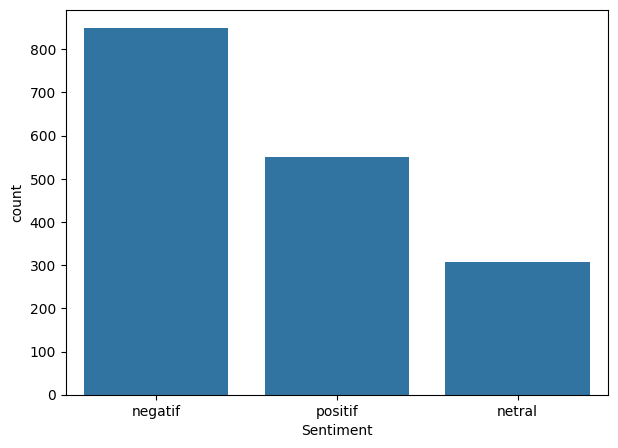

label
negatif    849
netral     308
positif    550
Name: count, dtype: int64

In [9]:
plt.figure(figsize=(7, 5))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.xlabel('Sentiment')
plt.show()

df['label'].value_counts().sort_index()

### Label Encoder

In [6]:
le = LabelEncoder()

df['label_encode'] = le.fit_transform(df['label'])
print(df.head())

                                              full_text    label  \
247   Sat Reskrim Unit Tipidkor Polres Pulau Buru Me...  positif   
1338  ðŸ¤£ðŸ¤£ðŸ¤£ sejarah terulang, padahal yg ngom...  positif   
803   Tempo korek dong kasus korupsi bahlil, berkasn...  positif   
252   Dilaporkan ke KPK akibat dugaan korupsi dan ko...  positif   
177   MENDUKUNG PROGRAM QUICK WINS PRESISI TAHUN 202...  positif   

                                       text_normalisasi  label_encode  
247   sat reskrim unit tipidkor polres pulau buru me...             2  
1338  sejarah terulang padahal yang mengomong juga m...             2  
803   tempo korek dong kasus korupsi bahlil berkasny...             2  
252   dilaporkan ke komisi pemberantasan korupsi aki...             2  
177   mendukung program quick wins presisi tahun uni...             2  


In [7]:
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_mapping)

{'negatif': 0, 'netral': 1, 'positif': 2}


In [8]:
LABEL_NAME = le.classes_
print(LABEL_NAME)

['negatif' 'netral' 'positif']


# Load Pre-Trained Word Vectors (Word2Vec)

In [9]:
%%time
WORD_EMBEDDING_PATH = 'model-word-embedding\idwiki-word2vec\idwiki-word2vec-300.wordvectors'

word2vec = KeyedVectors.load(WORD_EMBEDDING_PATH,  mmap='r')
#vocabulary = word2vec.wv.vocab     # gensim 3
vocabulary = word2vec.index_to_key # gensim 4
print('The numbers of words in vocabulary: ', len(vocabulary))

VOCAB_SIZE = len(vocabulary)
EMBEDDING_SIZE = word2vec.vector_size
EMBEDDING_SIZE

The numbers of words in vocabulary:  456474
CPU times: total: 234 ms
Wall time: 276 ms


300

In [10]:
word2vec_dict = {}

for word in vocabulary:
    #word2vec_dict[word] = word2vec.wv.get_vector(word)   # gensim 3
    word2vec_dict[word] = word2vec.get_vector(word)

print('The numbers of key-value pairs: ', len(word2vec_dict)) # should come equal to vocab size

The numbers of key-value pairs:  456474


In [11]:
# Cek vektor embedding dan dimensi dari suatu kata
word = 'yogyakarta'

print(word2vec[word])
print('Embedding size: ', word2vec[word].shape)

[ 1.5170839   1.086788   -0.1540106  -1.1036768  -1.1521944  -2.376956
  1.674137   -0.97332186 -2.5028708   0.854901    1.3386387   2.3730848
 -0.24650945  0.5194507  -0.45193434  0.08421133 -1.211181   -0.68709075
  2.6123157   0.68464553 -3.1177945   0.5134122   2.0982897  -1.5050308
  1.3415469  -1.2176394  -0.46404904  4.1940074  -0.9236465  -0.0065518
  1.3392074   1.3558999   0.7278997  -1.6559792  -0.49520814  0.37338695
 -0.57744235  0.2633397  -0.27121338  0.76295686  1.792065    0.6530777
 -1.6199683   2.0326202  -0.55119294  0.63287574 -1.4447671  -1.8711195
  0.01310196  0.457273    0.07608384 -1.6223986  -2.3040843  -0.54186463
 -0.9978265  -0.7623829   1.424659    3.153642   -3.2239697  -0.3104558
  0.09564466 -1.057154   -0.28272143  2.2221415   0.7723072   0.01840528
 -1.7182556  -0.27119923 -1.67151    -2.5104916  -0.0079566   0.7477621
  0.99297976  1.1478512  -0.12656358 -3.362374   -0.21108758  1.160634
 -2.6898367  -0.69321954  2.3124259   0.10986982 -0.9020368  -

# Memilih panjang maksimum of the Sequence

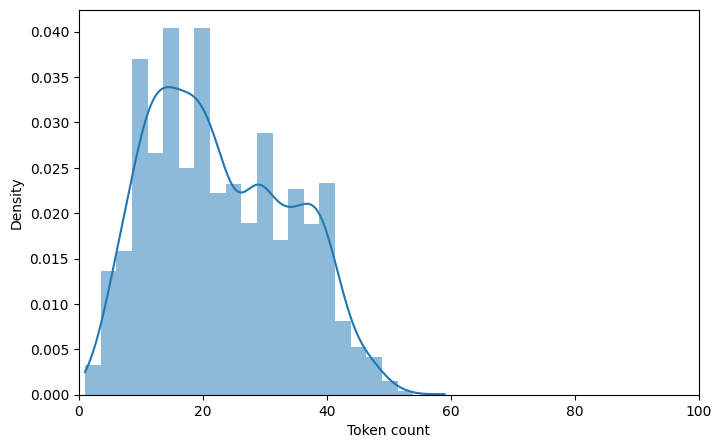

In [12]:
token_lens = []

for text in df['text_normalisasi']:
    tokens = text.split()
    token_lens.append(len(tokens))

plt.figure(figsize=(8, 5))
sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [13]:
MAX_SEQ_LENGTH = 50

# Persiapan Data untuk Embedding Layer

In [14]:
#------STOPWORDS--------------------
stop = stopwords.words('indonesian')
df['text_normalisasi'] = df['text_normalisasi'].apply(lambda x:' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,full_text,label,text_normalisasi,label_encode
247,Sat Reskrim Unit Tipidkor Polres Pulau Buru Me...,positif,sat reskrim unit tipidkor polres pulau buru me...,2
1338,"ðŸ¤£ðŸ¤£ðŸ¤£ sejarah terulang, padahal yg ngom...",positif,sejarah terulang mengomong mengulangi sejarah ...,2
803,"Tempo korek dong kasus korupsi bahlil, berkasn...",positif,tempo korek korupsi bahlil berkasnya kasih len...,2
252,Dilaporkan ke KPK akibat dugaan korupsi dan ko...,positif,dilaporkan komisi pemberantasan korupsi akibat...,2
177,MENDUKUNG PROGRAM QUICK WINS PRESISI TAHUN 202...,positif,mendukung program quick wins presisi unit tipi...,2


In [14]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

review = []
for index, row in df.iterrows():
    review.append(stemmer.stem(row["text_normalisasi"]))
    
df["text_normalisasi"] = review

### Tokenizing Data

In [15]:
NUM_WORDS = 500     # Frekuensi kemunculan kata. Hanya num_words-1 yang akan disimpan pada dictionary. Berarti kata dengan kemunculan <=num_words tidak digunakan.
OOV_TOKEN = '<unk>'   # Token khusus untuk mengganti kata yang tidak terdaftar dalam dictionary.

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV_TOKEN, lower=True, split=' ')
tokenizer.fit_on_texts(df['text_normalisasi'])

# Tambahkan token padding untuk menyamakan ukuran dimensi embedding layer
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

WV_DICTIONARY = tokenizer.word_index

WV_DICTIONARY_SIZE = len(WV_DICTIONARY)
print(WV_DICTIONARY_SIZE) # Lihat kata unik pada dictionary yang dihasilkan

5018


### Text to Sequence

In [16]:
# Proses mengubah token menjadi urutan bilangan int berdasarkan dictionary.
data_seq = tokenizer.texts_to_sequences(df['text_normalisasi'])

In [17]:
print(df['text_normalisasi'][1000])
print(data_seq[1])

1000    ksp indosurya angka fantastis pengin cepat ya ...
1000    ksp indosurya angka fantastis pengin cepat ya ...
1000    ksp indosurya angka fantastis pengin cepat ya ...
Name: text_normalisasi, dtype: object
[1, 1, 1, 1, 1, 2, 27]


### Add padding & Truncation

In [18]:
# Proses mengubah data dari sequence menjadi array bentuk 2D Numpy (num_samples, num_timesteps).
PADDING = 'pre'        # Berikan padding untuk setiap sequences. Terdapat dua pilihan dalam melakukan padding 'pre' or 'post'.
TRUNCATING = 'pre'     # Menghapus token dari sequences yang lebih besar dari max_lenght. Terdapat dua pilihan dalam melakukan truncanting 'pre' or 'post'.

data_pad = pad_sequences(data_seq, maxlen=MAX_SEQ_LENGTH, padding=PADDING, truncating=TRUNCATING)

In [19]:
print(df['text_normalisasi'][1000])
print(data_seq[1000])
print(data_pad[1000])

1000    ksp indosurya angka fantastis pengin cepat ya ...
1000    ksp indosurya angka fantastis pengin cepat ya ...
1000    ksp indosurya angka fantastis pengin cepat ya ...
Name: text_normalisasi, dtype: object
[1, 78, 84, 328, 70, 2, 45]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   1  78  84 328  70   2  45]


In [20]:
data_pad.shape

(2700, 70)

### Membuat matriks embedding

In [21]:
EMBEDDING_MATRIX = np.zeros(shape=(WV_DICTIONARY_SIZE, EMBEDDING_SIZE))

for word, i in tokenizer.word_index.items():
    embed_vector = word2vec_dict.get(word)
    if embed_vector is not None:               # Word is in the vocabulary learned by the w2v model
        EMBEDDING_MATRIX[i] = embed_vector

In [22]:
print(WV_DICTIONARY.get('presiden'))

67


In [23]:
print(EMBEDDING_MATRIX[33])

[ 0.30817437 -0.40021628 -0.89674968 -2.4026463   0.15952173  0.79680568
  2.56865001 -0.82549858 -1.28926361  3.61835146  1.22065854  6.13206053
 -1.83438289 -1.28925824 -0.07049716  2.41390944 -0.82841063 -2.87467742
 -3.14349818 -0.83977461 -0.82091963 -0.3393518  -0.46154347 -0.81377012
 -2.18455887 -4.69224977  0.48842824  2.43364739 -2.19185877 -1.09116793
 -0.50722152  1.18378592 -1.47221196  1.93931222  0.09180029  2.35910535
 -0.11697265 -1.61527491  0.59050947  0.57152116 -2.88531017  0.24799572
  2.01448298 -0.69065756 -1.43383288  1.87673807 -1.55153322  0.44653234
 -0.46419898 -2.92005134  1.6718111  -0.1743429  -0.26360324 -2.87338567
  0.57966059 -4.33497047  0.71824759  0.30515334 -0.18581589  1.23851335
  1.14125514 -1.98040581 -2.21037507  0.1898022  -4.08423233  2.12028003
 -4.85752058  1.35993791 -0.70996612 -2.59514856  3.00465488  2.31761527
  3.25602365  1.32722151  0.64379489 -0.50237656 -0.65860593 -0.43082568
 -2.88287878  0.8112781   0.86004788 -0.37662685  0

In [24]:
EMBEDDING_MATRIX.shape

(5018, 300)

## Train & Test Data Splitting

In [25]:
NUM_CLASS = len(df['label_encode'].unique())

Y = to_categorical(df['label_encode'], num_classes=NUM_CLASS)  # Lakukan one-hot encoding pada label (y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data_pad, Y, test_size=0.2, stratify=Y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2160, 70), (540, 70), (2160, 3), (540, 3))

# Model

### RNN

In [27]:
UNITS = 128

tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,
    output_dim = EMBEDDING_SIZE,
    input_length = MAX_SEQ_LENGTH,
    #trainable = False,
    embeddings_initializer=Constant(EMBEDDING_MATRIX)))
model.add(SimpleRNN(UNITS, dropout=0.5, return_sequences=False))
model.add(Dense(NUM_CLASS, activation='softmax'))

In [29]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

UNITS = 128

X = data_pad
y = Y

accuracy_scores = []
precision_scores = []
recall_scores = []
efwan = []
loss_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(Embedding(
        input_dim = WV_DICTIONARY_SIZE,
        output_dim = EMBEDDING_SIZE,
        input_length = MAX_SEQ_LENGTH,
        #trainable = True,
        embeddings_initializer=Constant(EMBEDDING_MATRIX)))
    model.add(SimpleRNN(UNITS, dropout=0.5, return_sequences=False))
    model.add(Dense(NUM_CLASS, activation='softmax'))
    
    METRICS = [
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
    ]

    LEARNING_RATE = 0.005

    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
    LOSS_FUNCTION = CategoricalCrossentropy(name='categorical_crossentropy')

    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=METRICS)
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)
    
    EPOCHS = 20
    BATCH_SIZE = 32

    model_history = model.fit(
        X_train, 
        y_train, 
        epochs=EPOCHS,
        batch_size=BATCH_SIZE, 
        validation_data=(X_test, y_test), 
        verbose=1, 
        steps_per_epoch=int(np.ceil(X_train.shape[0] / BATCH_SIZE)),
        callbacks=[early_stopping]
    )
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    print(classification_report(y_true, y_pred))
    print("=================================================")
    
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, average='macro'))
    recall_scores.append(recall_score(y_true, y_pred, average='macro'))
    efwan.append(f1_score(y_true, y_pred, average='macro'))
    loss_scores.append(evaluation[0])
    
print()
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(efwan)
avg_loss = sum(loss_scores) / len(loss_scores)

print("Rata-rata Akurasi: ", round(avg_accuracy,4))
print("Rata-rata Precision: ", round(avg_precision,4))
print("Rata-rata Recall: ", round(avg_recall,4))
print("Rata-rata F1-score: ", round(avg_f1,4))
print("Rata-rata Loss: {:.4f}".format(avg_loss))

Epoch 1/20
68/68 [==============================] - 6s 69ms/step - loss: 1.1912 - accuracy: 0.4282 - precision: 0.4644 - recall: 0.3227 - val_loss: 1.0066 - val_accuracy: 0.4926 - val_precision: 0.6028 - val_recall: 0.3204
Epoch 2/20
68/68 [==============================] - 4s 63ms/step - loss: 0.9549 - accuracy: 0.5431 - precision: 0.6263 - recall: 0.3972 - val_loss: 0.9236 - val_accuracy: 0.5315 - val_precision: 0.5587 - val_recall: 0.4407
Epoch 3/20
68/68 [==============================] - 4s 65ms/step - loss: 0.8517 - accuracy: 0.5824 - precision: 0.6789 - recall: 0.4551 - val_loss: 0.8590 - val_accuracy: 0.5963 - val_precision: 0.6760 - val_recall: 0.4481
Epoch 4/20
68/68 [==============================] - 4s 61ms/step - loss: 0.7919 - accuracy: 0.6301 - precision: 0.7048 - recall: 0.5338 - val_loss: 0.9401 - val_accuracy: 0.5889 - val_precision: 0.6128 - val_recall: 0.5333
Epoch 5/20
68/68 [==============================] - 4s 62ms/step - loss: 0.8209 - accuracy: 0.6157 - precisi

68/68 [==============================] - 4s 60ms/step - loss: 0.7878 - accuracy: 0.6241 - precision: 0.6881 - recall: 0.5208 - val_loss: 0.8723 - val_accuracy: 0.6148 - val_precision: 0.6830 - val_recall: 0.4907
Epoch 8: early stopping
17/17 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0       0.56      0.60      0.58       177
           1       0.74      0.61      0.67       191
           2       0.57      0.63      0.60       172

    accuracy                           0.61       540
   macro avg       0.62      0.61      0.62       540
weighted avg       0.62      0.61      0.62       540


Rata-rata Akurasi:  0.6385
Rata-rata Precision:  0.6525
Rata-rata Recall:  0.6394
Rata-rata F1-score:  0.6352
Rata-rata Loss: 0.8208


### LSTM

In [94]:
units = 128

tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,
    output_dim = EMBEDDING_SIZE,
    input_length = MAX_SEQ_LENGTH,
    #trainable = True,
    embeddings_initializer=Constant(EMBEDDING_MATRIX)))
model.add(LSTM(units, dropout=0.5, return_sequences=False))
model.add(Dense(NUM_CLASS, activation='softmax'))

In [34]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

UNITS = 128

X = data_pad
y = Y

accuracy_scores = []
precision_scores = []
recall_scores = []
efwan = []
loss_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(Embedding(
        input_dim = WV_DICTIONARY_SIZE,
        output_dim = EMBEDDING_SIZE,
        input_length = MAX_SEQ_LENGTH,
        #trainable = True,
        embeddings_initializer=Constant(EMBEDDING_MATRIX)))
    model.add(LSTM(UNITS, dropout=0.5, return_sequences=False))
    model.add(Dense(NUM_CLASS, activation='softmax'))
    
    METRICS = [
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
    ]

    LEARNING_RATE = 0.005

    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
    LOSS_FUNCTION = CategoricalCrossentropy(name='categorical_crossentropy')

    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=METRICS)
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)
    
    EPOCHS = 50
    BATCH_SIZE = 32

    model_history = model.fit(
        X_train, 
        y_train, 
        epochs=EPOCHS,
        batch_size=BATCH_SIZE, 
        validation_data=(X_test, y_test), 
        verbose=1, 
        steps_per_epoch=int(np.ceil(X_train.shape[0] / BATCH_SIZE)),
        callbacks=[early_stopping]
    )
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    print(classification_report(y_true, y_pred))
    print("=================================================")
    
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, average='macro'))
    recall_scores.append(recall_score(y_true, y_pred, average='macro'))
    efwan.append(f1_score(y_true, y_pred, average='macro'))
    loss_scores.append(evaluation[0])
    
print()
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(efwan)
avg_loss = sum(loss_scores) / len(loss_scores)

print("Rata-rata Akurasi: ", round(avg_accuracy,4))
print("Rata-rata Precision: ", round(avg_precision,4))
print("Rata-rata Recall: ", round(avg_recall,4))
print("Rata-rata F1-score: ", round(avg_f1,4))
print("Rata-rata Loss: {:.4f}".format(avg_loss))


Epoch 1/50
68/68 [==============================] - 6s 70ms/step - loss: 0.9705 - accuracy: 0.5278 - precision: 0.5967 - recall: 0.3301 - val_loss: 0.8187 - val_accuracy: 0.6333 - val_precision: 0.6779 - val_recall: 0.5222
Epoch 2/50
68/68 [==============================] - 4s 59ms/step - loss: 0.7077 - accuracy: 0.7023 - precision: 0.7356 - recall: 0.6194 - val_loss: 0.6608 - val_accuracy: 0.7074 - val_precision: 0.7479 - val_recall: 0.6537
Epoch 3/50
68/68 [==============================] - 4s 61ms/step - loss: 0.5345 - accuracy: 0.7806 - precision: 0.8128 - recall: 0.7458 - val_loss: 0.5901 - val_accuracy: 0.7611 - val_precision: 0.7892 - val_recall: 0.7278
Epoch 4/50
68/68 [==============================] - 4s 62ms/step - loss: 0.4118 - accuracy: 0.8366 - precision: 0.8631 - recall: 0.8111 - val_loss: 0.5438 - val_accuracy: 0.8000 - val_precision: 0.8076 - val_recall: 0.7852
Epoch 5/50
68/68 [==============================] - 4s 63ms/step - loss: 0.3506 - accuracy: 0.8662 - precisi

Epoch 4/50
68/68 [==============================] - 5s 73ms/step - loss: 0.4066 - accuracy: 0.8542 - precision: 0.8674 - recall: 0.8204 - val_loss: 0.5170 - val_accuracy: 0.8278 - val_precision: 0.8489 - val_recall: 0.8222
Epoch 5/50
68/68 [==============================] - 5s 77ms/step - loss: 0.3154 - accuracy: 0.8856 - precision: 0.8996 - recall: 0.8708 - val_loss: 0.5052 - val_accuracy: 0.8296 - val_precision: 0.8403 - val_recall: 0.8185
Epoch 6/50
68/68 [==============================] - 5s 75ms/step - loss: 0.2966 - accuracy: 0.8912 - precision: 0.9005 - recall: 0.8801 - val_loss: 0.5159 - val_accuracy: 0.8204 - val_precision: 0.8302 - val_recall: 0.8148
Epoch 7/50
68/68 [==============================] - 5s 73ms/step - loss: 0.2393 - accuracy: 0.9153 - precision: 0.9261 - recall: 0.9046 - val_loss: 0.5100 - val_accuracy: 0.8352 - val_precision: 0.8511 - val_recall: 0.8259
Epoch 8/50
68/68 [==============================] - 5s 73ms/step - loss: 0.1754 - accuracy: 0.9347 - precisi

### Bi-LSTM

In [29]:
UNITS = 64

tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,                                
    output_dim = EMBEDDING_SIZE,                           
    input_length = MAX_SEQ_LENGTH,  
    #trainable = False,
    embeddings_initializer=Constant(EMBEDDING_MATRIX)))
model.add(Bidirectional(LSTM(UNITS, dropout=0.5, return_sequences=False)))
model.add(Dense(UNITS, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(NUM_CLASS, activation='softmax'))

In [38]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

UNITS = 128

X = data_pad
y = Y

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
loss_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(Embedding(
        input_dim = WV_DICTIONARY_SIZE,                                
        output_dim = EMBEDDING_SIZE,                           
        input_length = MAX_SEQ_LENGTH,  
        #trainable = False,
        embeddings_initializer=Constant(EMBEDDING_MATRIX)))
    model.add(Bidirectional(LSTM(UNITS, dropout=0.5, return_sequences=False)))
    model.add(Dense(UNITS, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASS, activation='softmax'))
    
    METRICS = [
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
    ]

    LEARNING_RATE = 0.005

    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
    LOSS_FUNCTION = CategoricalCrossentropy(name='categorical_crossentropy')

    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=METRICS)
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)
    
    EPOCHS = 10
    BATCH_SIZE = 32

    model_history = model.fit(
        X_train, 
        y_train, 
        epochs=EPOCHS,
        batch_size=BATCH_SIZE, 
        validation_data=(X_test, y_test), 
        verbose=1, 
        steps_per_epoch=int(np.ceil(X_train.shape[0] / BATCH_SIZE)),
        callbacks=[early_stopping]
    )
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    print(classification_report(y_true, y_pred))
    print("=================================================")
    
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(evaluation[1])
    precision_scores.append(evaluation[1])
    recall_scores.append(evaluation[1])
    f1_scores.append(evaluation[1])
    loss_scores.append(evaluation[0])
    
print()
avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_f1 = sum(f1_scores) / len(f1_scores)
avg_loss = sum(loss_scores) / len(loss_scores)
print("Average Accuracy: {:.4f}".format(avg_accuracy))
print("Average Precision: {:.4f}".format(avg_precision))
print("Average Recall: {:.4f}".format(avg_recall))
print("Average F1-score: {:.4f}".format(avg_f1))
print("Average Loss: {:.4f}".format(avg_loss))


Epoch 1/10
68/68 [==============================] - 11s 121ms/step - loss: 0.9993 - accuracy: 0.4894 - precision: 0.6000 - recall: 0.2583 - val_loss: 0.8792 - val_accuracy: 0.5630 - val_precision: 0.6143 - val_recall: 0.4630
Epoch 2/10
68/68 [==============================] - 7s 109ms/step - loss: 0.7433 - accuracy: 0.6694 - precision: 0.7304 - recall: 0.5819 - val_loss: 1.0319 - val_accuracy: 0.5778 - val_precision: 0.6057 - val_recall: 0.5463
Epoch 3/10
68/68 [==============================] - 8s 112ms/step - loss: 0.5863 - accuracy: 0.7579 - precision: 0.7879 - recall: 0.7241 - val_loss: 0.6001 - val_accuracy: 0.7648 - val_precision: 0.8146 - val_recall: 0.7241
Epoch 4/10
68/68 [==============================] - 8s 113ms/step - loss: 0.4541 - accuracy: 0.8208 - precision: 0.8400 - recall: 0.7972 - val_loss: 0.6896 - val_accuracy: 0.7370 - val_precision: 0.7486 - val_recall: 0.7278
Epoch 5/10
68/68 [==============================] - 8s 114ms/step - loss: 0.3874 - accuracy: 0.8440 - p

Epoch 2/10
68/68 [==============================] - 8s 119ms/step - loss: 0.7462 - accuracy: 0.6574 - precision: 0.7147 - recall: 0.5764 - val_loss: 0.7308 - val_accuracy: 0.6889 - val_precision: 0.7309 - val_recall: 0.6037
Epoch 3/10
68/68 [==============================] - 8s 122ms/step - loss: 0.5915 - accuracy: 0.7602 - precision: 0.7914 - recall: 0.7130 - val_loss: 0.6437 - val_accuracy: 0.7444 - val_precision: 0.7695 - val_recall: 0.6926
Epoch 4/10
68/68 [==============================] - 8s 121ms/step - loss: 0.4407 - accuracy: 0.8245 - precision: 0.8449 - recall: 0.7995 - val_loss: 0.6102 - val_accuracy: 0.7963 - val_precision: 0.8137 - val_recall: 0.7685
Epoch 5/10
68/68 [==============================] - 8s 120ms/step - loss: 0.3632 - accuracy: 0.8556 - precision: 0.8686 - recall: 0.8384 - val_loss: 0.6457 - val_accuracy: 0.7778 - val_precision: 0.7854 - val_recall: 0.7593
Epoch 6/10
68/68 [==============================] - 8s 120ms/step - loss: 0.2881 - accuracy: 0.8880 - pr

### GRU

In [62]:
units = 128

tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,
    output_dim = EMBEDDING_SIZE,
    input_length = MAX_SEQ_LENGTH,
    #trainable = True,
    embeddings_initializer=Constant(EMBEDDING_MATRIX)))
model.add(GRU(units, dropout=0.5, return_sequences=False))
model.add(Dense(NUM_CLASS, activation='softmax'))

In [36]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

UNITS = 128

X = data_pad
y = Y

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
loss_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(Embedding(
        input_dim = WV_DICTIONARY_SIZE,
        output_dim = EMBEDDING_SIZE,
        input_length = MAX_SEQ_LENGTH,
        #trainable = True,
        embeddings_initializer=Constant(EMBEDDING_MATRIX)))
    model.add(GRU(UNITS, dropout=0.5, return_sequences=False))
    model.add(Dense(NUM_CLASS, activation='softmax'))
    
    METRICS = [
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
    ]

    LEARNING_RATE = 0.005

    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
    LOSS_FUNCTION = CategoricalCrossentropy(name='categorical_crossentropy')

    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=METRICS)
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)
    
    EPOCHS = 10
    BATCH_SIZE = 32

    model_history = model.fit(
        X_train, 
        y_train, 
        epochs=EPOCHS,
        batch_size=BATCH_SIZE, 
        validation_data=(X_test, y_test), 
        verbose=1, 
        steps_per_epoch=int(np.ceil(X_train.shape[0] / BATCH_SIZE)),
        callbacks=[early_stopping]
    )
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    print(classification_report(y_true, y_pred))
    print("=================================================")
    
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, average='macro'))
    recall_scores.append(recall_score(y_true, y_pred, average='macro'))
    f1_scores.append(f1_score(y_true, y_pred, average='macro'))
    loss_scores.append(evaluation[0])
    
print()
avg_accuracy = np.mean(accuracy_scores)*100
avg_precision = np.mean(precision_scores)*100
avg_recall = np.mean(recall_scores)*100
avg_f1 = np.mean(f1_scores)*100
avg_loss = sum(loss_scores) / len(loss_scores)
print("Rata-rata Akurasi: ", round(avg_accuracy,4))
print("Rata-rata Precision: ", round(avg_precision,4))
print("Rata-rata Recall: ", round(avg_recall,4))
print("Rata-rata F1-score: ", round(avg_f1,4))
print("Rata-rata Loss: {:.4f}".format(avg_loss))


Epoch 1/10
68/68 [==============================] - 7s 74ms/step - loss: 1.0325 - accuracy: 0.4847 - precision: 0.5453 - recall: 0.3370 - val_loss: 0.8030 - val_accuracy: 0.6722 - val_precision: 0.7361 - val_recall: 0.5630
Epoch 2/10
68/68 [==============================] - 4s 66ms/step - loss: 0.7258 - accuracy: 0.6907 - precision: 0.7331 - recall: 0.6028 - val_loss: 0.6560 - val_accuracy: 0.7389 - val_precision: 0.7824 - val_recall: 0.6926
Epoch 3/10
68/68 [==============================] - 5s 68ms/step - loss: 0.5728 - accuracy: 0.7755 - precision: 0.8026 - recall: 0.7361 - val_loss: 0.5611 - val_accuracy: 0.7759 - val_precision: 0.8111 - val_recall: 0.7315
Epoch 4/10
68/68 [==============================] - 5s 69ms/step - loss: 0.4559 - accuracy: 0.8213 - precision: 0.8429 - recall: 0.7995 - val_loss: 0.6303 - val_accuracy: 0.7648 - val_precision: 0.7752 - val_recall: 0.7537
Epoch 5/10
68/68 [==============================] - 5s 69ms/step - loss: 0.4071 - accuracy: 0.8426 - precisi

Epoch 3/10
68/68 [==============================] - 5s 71ms/step - loss: 0.5447 - accuracy: 0.7870 - precision: 0.8200 - recall: 0.7468 - val_loss: 0.5628 - val_accuracy: 0.7944 - val_precision: 0.8202 - val_recall: 0.7519
Epoch 4/10
68/68 [==============================] - 5s 73ms/step - loss: 0.4592 - accuracy: 0.8194 - precision: 0.8470 - recall: 0.7921 - val_loss: 0.4997 - val_accuracy: 0.8333 - val_precision: 0.8390 - val_recall: 0.8204
Epoch 5/10
68/68 [==============================] - 5s 74ms/step - loss: 0.3712 - accuracy: 0.8560 - precision: 0.8725 - recall: 0.8394 - val_loss: 0.5408 - val_accuracy: 0.8222 - val_precision: 0.8359 - val_recall: 0.8019
Epoch 6/10
68/68 [==============================] - 5s 72ms/step - loss: 0.3265 - accuracy: 0.8810 - precision: 0.8901 - recall: 0.8662 - val_loss: 0.5648 - val_accuracy: 0.8389 - val_precision: 0.8431 - val_recall: 0.8259
Epoch 7/10
68/68 [==============================] - 5s 72ms/step - loss: 0.2838 - accuracy: 0.8917 - precisi

### Bi-GRU

In [52]:
UNITS = 128

tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(
    input_dim = WV_DICTIONARY_SIZE,
    output_dim = EMBEDDING_SIZE,
    input_length = MAX_SEQ_LENGTH,
    #trainable = False,
    embeddings_initializer=Constant(EMBEDDING_MATRIX)))
model.add(Bidirectional(GRU(UNITS, dropout=0.5, return_sequences=False)))
model.add(Dense(UNITS))
#model.add(Dropout(0.5))
model.add(Dense(NUM_CLASS, activation='softmax'))

In [39]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

UNITS = 128

X = data_pad
y = Y

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
loss_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(Embedding(
        input_dim = WV_DICTIONARY_SIZE,
        output_dim = EMBEDDING_SIZE,
        input_length = MAX_SEQ_LENGTH,
        #trainable = True,
        embeddings_initializer=Constant(EMBEDDING_MATRIX)))
    model.add(Bidirectional(GRU(UNITS, dropout=0.5, return_sequences=False)))
    model.add(Dense(UNITS, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASS, activation='softmax'))
    
    METRICS = [
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
    ]

    LEARNING_RATE = 0.005

    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
    LOSS_FUNCTION = CategoricalCrossentropy(name='categorical_crossentropy')

    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=METRICS)
    
    early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)
    
    EPOCHS = 10
    BATCH_SIZE = 32

    model_history = model.fit(
        X_train, 
        y_train, 
        epochs=EPOCHS,
        batch_size=BATCH_SIZE, 
        validation_data=(X_test, y_test), 
        verbose=1, 
        steps_per_epoch=int(np.ceil(X_train.shape[0] / BATCH_SIZE)),
        callbacks=[early_stopping]
    )
    
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    print(classification_report(y_true, y_pred))
    print("=================================================")
    
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    accuracy_scores.append(accuracy_score(y_true, y_pred))
    precision_scores.append(precision_score(y_true, y_pred, average='macro'))
    recall_scores.append(recall_score(y_true, y_pred, average='macro'))
    f1_scores.append(f1_score(y_true, y_pred, average='macro'))
    loss_scores.append(evaluation[0])
    
print()
avg_accuracy = np.mean(accuracy_scores)*100
avg_precision = np.mean(precision_scores)*100
avg_recall = np.mean(recall_scores)*100
avg_f1 = np.mean(f1_scores)*100
avg_loss = sum(loss_scores) / len(loss_scores)
print("Rata-rata Akurasi: ", round(avg_accuracy,4))
print("Rata-rata Precision: ", round(avg_precision,4))
print("Rata-rata Recall: ", round(avg_recall,4))
print("Rata-rata F1-score: ", round(avg_f1,4))
print("Rata-rata Loss: {:.4f}".format(avg_loss))


Epoch 1/10
68/68 [==============================] - 31s 184ms/step - loss: 1.0001 - accuracy: 0.4940 - precision: 0.5693 - recall: 0.2949 - val_loss: 0.8334 - val_accuracy: 0.6167 - val_precision: 0.6609 - val_recall: 0.4981
Epoch 2/10
68/68 [==============================] - 10s 151ms/step - loss: 0.7717 - accuracy: 0.6597 - precision: 0.7085 - recall: 0.5671 - val_loss: 0.7111 - val_accuracy: 0.6944 - val_precision: 0.7298 - val_recall: 0.6352
Epoch 3/10
68/68 [==============================] - 10s 146ms/step - loss: 0.6274 - accuracy: 0.7403 - precision: 0.7734 - recall: 0.6935 - val_loss: 0.6060 - val_accuracy: 0.7593 - val_precision: 0.7778 - val_recall: 0.7130
Epoch 4/10
68/68 [==============================] - 10s 145ms/step - loss: 0.5114 - accuracy: 0.7884 - precision: 0.8142 - recall: 0.7588 - val_loss: 0.6354 - val_accuracy: 0.7796 - val_precision: 0.7886 - val_recall: 0.7667
Epoch 5/10
68/68 [==============================] - 10s 146ms/step - loss: 0.4624 - accuracy: 0.8171

Epoch 5/10
68/68 [==============================] - 12s 176ms/step - loss: 0.4485 - accuracy: 0.8181 - precision: 0.8409 - recall: 0.7903 - val_loss: 0.5050 - val_accuracy: 0.8167 - val_precision: 0.8353 - val_recall: 0.7704
Epoch 6/10
68/68 [==============================] - 12s 177ms/step - loss: 0.3710 - accuracy: 0.8560 - precision: 0.8697 - recall: 0.8407 - val_loss: 0.4777 - val_accuracy: 0.8259 - val_precision: 0.8426 - val_recall: 0.8130
Epoch 7/10
68/68 [==============================] - 12s 180ms/step - loss: 0.3511 - accuracy: 0.8611 - precision: 0.8714 - recall: 0.8505 - val_loss: 0.4761 - val_accuracy: 0.8315 - val_precision: 0.8496 - val_recall: 0.8056
Epoch 8/10
68/68 [==============================] - 12s 170ms/step - loss: 0.3198 - accuracy: 0.8796 - precision: 0.8912 - recall: 0.8606 - val_loss: 0.4902 - val_accuracy: 0.8611 - val_precision: 0.8691 - val_recall: 0.8481
Epoch 9/10
68/68 [==============================] - 12s 172ms/step - loss: 0.2539 - accuracy: 0.9000

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 300)           1515300   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,735,335
Trainable params: 1,735,335
Non-trainable params: 0
_________________________________________________________________


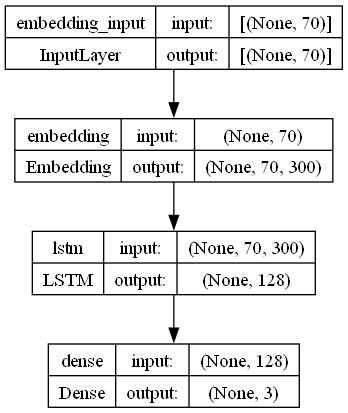

In [95]:
model.summary()
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='sent_analysis_model.png')

## Compile

In [96]:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics

METRICS = [
           tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'), 
]

LEARNING_RATE = 0.005

OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS_FUNCTION = CategoricalCrossentropy(name='categorical_crossentropy')
#LOSS_FUNCTION = BinaryCrossentropy(name='binary_crossentropy')

model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=METRICS)

## Early Stopping

In [97]:
# Early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)

# Path to model checkpoint
checkpoint_dir = f'{FOLDER_PATH}/model-checkpoint/{MODEL}/cp.ckpt'
model_checkpoint = ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', save_weights_only=True, verbose=1, save_freq='epoch', save_best_only=True)

In [60]:

early_stopping = EarlyStopping(
    restore_best_weights=True,
    patience=3, 
    min_delta=0.01, 
    mode='max',
    monitor='val_loss'
)

In [90]:
# Path to model log
log_dir = f'{FOLDER_PATH}/model-log/{MODEL}/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
print(log_dir)

model-baseline-bilstm/model-log/id-wiki-word2vec-bilstm/20231110-003237


In [91]:
tensorboard_callback = TensorBoard(log_dir=log_dir ,update_freq='epoch', histogram_freq=1, embeddings_freq=1)

## Training dan Testing

### Training

In [98]:
%%time
EPOCHS = 10
BATCH_SIZE = 32

model_history = model.fit(
    X_train, 
    y_train, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_test, y_test), 
    verbose=1, 
    steps_per_epoch=int(np.ceil(X_train.shape[0] / BATCH_SIZE)),
    callbacks=[early_stopping]
)

Epoch 1/10
68/68 [==============================] - 6s 65ms/step - loss: 0.9729 - accuracy: 0.5389 - precision: 0.6137 - recall: 0.3287 - val_loss: 0.7848 - val_accuracy: 0.6704 - val_precision: 0.7117 - val_recall: 0.5167
Epoch 2/10
68/68 [==============================] - 4s 59ms/step - loss: 0.7039 - accuracy: 0.6875 - precision: 0.7369 - recall: 0.6056 - val_loss: 0.6308 - val_accuracy: 0.7389 - val_precision: 0.7716 - val_recall: 0.6944
Epoch 3/10
68/68 [==============================] - 4s 61ms/step - loss: 0.5459 - accuracy: 0.7815 - precision: 0.8124 - recall: 0.7380 - val_loss: 0.5641 - val_accuracy: 0.7685 - val_precision: 0.7925 - val_recall: 0.7426
Epoch 4/10
68/68 [==============================] - 4s 63ms/step - loss: 0.4267 - accuracy: 0.8315 - precision: 0.8521 - recall: 0.8056 - val_loss: 0.5134 - val_accuracy: 0.8093 - val_precision: 0.8212 - val_recall: 0.7907
Epoch 5/10
68/68 [==============================] - 4s 61ms/step - loss: 0.3527 - accuracy: 0.8616 - precisi

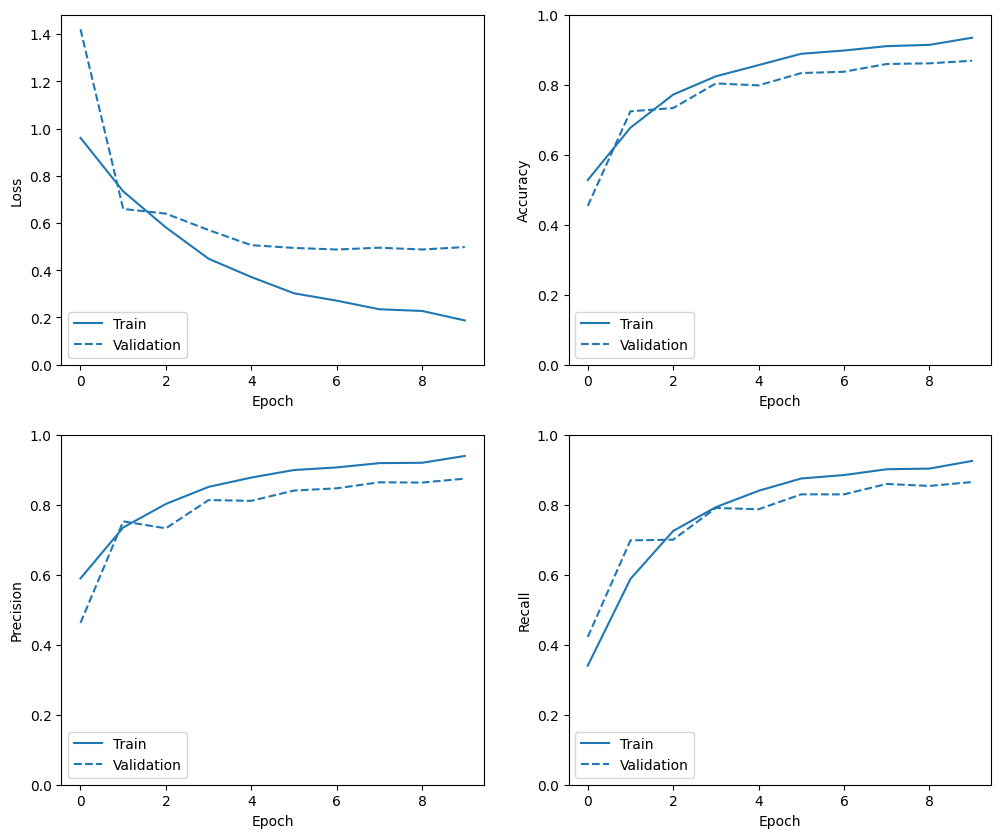

In [35]:
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 
             'precision', 'recall'
            ]
  plt.figure(figsize=(12, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace('_',' ').capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle='--',label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend(loc='lower left');
    
plot_metrics(model_history)

In [58]:
hist_df = pd.DataFrame(model_history.history)
print(hist_df)

#hist_df.to_csv(f'{FOLDER_PATH}/model-history/{MODEL}-{TODAY}.csv')

       loss  accuracy  precision    recall  val_loss  val_accuracy  \
0  0.973912  0.513426   0.593548  0.298148  0.847103      0.624074   
1  0.752715  0.666204   0.709714  0.575000  0.778094      0.653704   
2  0.588866  0.752778   0.781828  0.705093  0.653687      0.774074   
3  0.524163  0.787500   0.810568  0.752778  0.574244      0.766667   
4  0.401470  0.835648   0.849639  0.816204  0.500763      0.829630   
5  0.323810  0.878704   0.888042  0.862963  0.497620      0.816667   
6  0.258871  0.910185   0.918944  0.902778  0.505741      0.853704   
7  0.250931  0.901852   0.909647  0.894907  0.451466      0.864815   
8  0.217241  0.922222   0.926795  0.914352  0.495576      0.868519   
9  0.205561  0.924074   0.929345  0.913426  0.487506      0.872222   

   val_precision  val_recall  
0       0.669516    0.435185  
1       0.687898    0.600000  
2       0.792608    0.714815  
3       0.797217    0.742593  
4       0.850000    0.818519  
5       0.834615    0.803704  
6       0.85

# Evaluasi

In [93]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy*100))

f1_score = 2 * (precision * recall) / (precision + recall)
f1_score

17/17 [==============================] - 0s 14ms/step - loss: 0.4833 - accuracy: 0.8611 - precision: 0.8654 - recall: 0.8574
Accuracy: 86.11%


0.8613953500853927

### Confusion Matriks

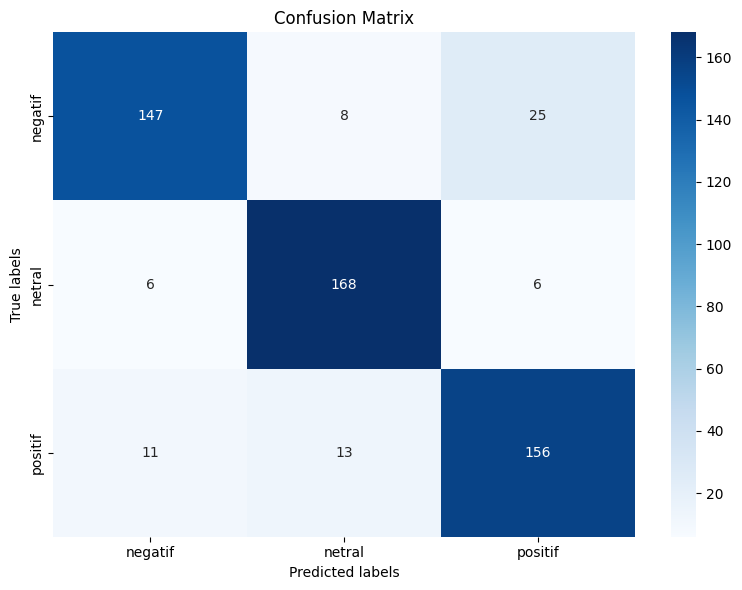

In [60]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')  # annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(LABEL_NAME)
ax.yaxis.set_ticklabels(LABEL_NAME)
plt.tight_layout()

In [104]:
print(classification_report(y_pred, y_true, target_names=LABEL_NAME))

              precision    recall  f1-score   support

     negatif       0.84      0.89      0.87       170
      netral       0.96      0.92      0.94       186
     positif       0.87      0.85      0.86       184

    accuracy                           0.89       540
   macro avg       0.89      0.89      0.89       540
weighted avg       0.89      0.89      0.89       540



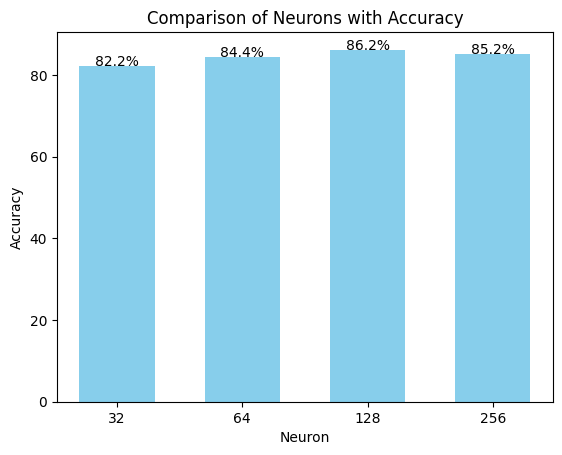

In [12]:
hidden = [32, 64, 128, 256]
accuracies = [82.22, 84.44, 86.15, 85.15]  # Contoh nilai akurasi

x = range(len(hidden))
width = 0.6

fig, ax = plt.subplots()
ax.bar([i + 0.1 for i in x], accuracies, width, color='skyblue')
ax.set_xlabel('Neuron')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Neurons with Accuracy')
ax.set_xticks([i + 0.1 for i in x])
ax.set_xticklabels(hidden)

# Menambahkan label persentase pada setiap bar
for i, v in enumerate(accuracies):
    ax.text(i + 0.1, v + 0.01, f'{v:.1f}%', ha='center')

plt.show()

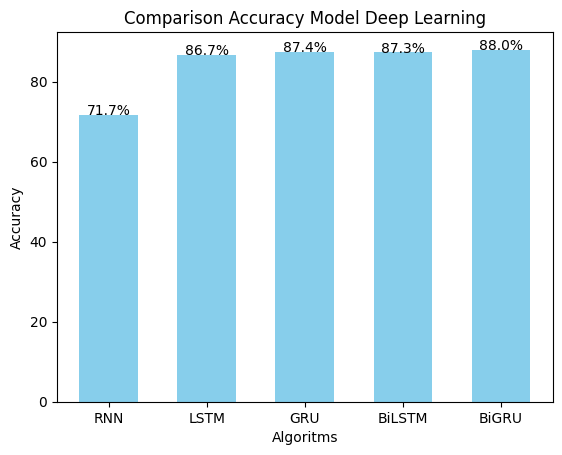

In [10]:
algorithms = ['RNN', 'LSTM', 'GRU', 'BiLSTM', 'BiGRU']
accuracies = [71.74, 86.71, 87.44, 87.33, 88]  # Contoh nilai akurasi

x = range(len(algorithms))
width = 0.6

fig, ax = plt.subplots()
ax.bar([i + 0.1 for i in x], accuracies, width, color='skyblue')
ax.set_xlabel('Algoritms')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison Accuracy Model Deep Learning')
ax.set_xticks([i + 0.1 for i in x])
ax.set_xticklabels(algorithms)

# Menambahkan label persentase pada setiap bar
for i, v in enumerate(accuracies):
    ax.text(i + 0.1, v + 0.01, f'{v:.1f}%', ha='center')

plt.show()